This notebook compares the email activities and draft activites of an IETF working group.

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

In [1]:
import bigbang.mailman as mailman
from bigbang.parse import get_date
#from bigbang.functions import *
from bigbang.archive import Archive

from ietfdata.datatracker import *

/home/sb/projects/bigbang-multi/bigbang/config/config.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dictionary = yaml.load(stream)


Also, let's import a number of other dependencies we'll use later.

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os

Now let's load the email data for analysis.

In [3]:
urls = ["hrpc"]

archives = [Archive(url,mbox=True) for url in urls]

activities = [arx.get_activity(resolved=False) for arx in archives]

/home/sb/projects/bigbang-multi/bigbang/bigbang/mailman.py:157: UserWarning: No mailing list name found at hrpc
  warnings.warn("No mailing list name found at %s" % url)


Next, we will use the `ietfdata` tracker to look at the frequency of drafts for this working group.

In [4]:
dt = DataTracker()

group = dt.group_from_acronym('hrpc')

def extract_data(doc):
    data = {}
    data['title'] = doc.title
    data['time'] = doc.time
    data['affiliation'] = [
        doc_author.affiliation
        for doc_author
        in dt.document_authors(doc)
    ]
    data['group-acronym'] = dt.group(doc.group).acronym
    data['type'] = doc.type.uri

    return data

drafts = dt.documents(group = group,
                      doctype = dt.document_type(
                          DocumentTypeURI("/api/v1/name/doctypename/draft")))

draft_df = pd.DataFrame(data=[extract_data(x) for x in drafts])

In [5]:
draft_df['time'].dt.date.drop_duplicates().sort_values()

0    2016-08-27
2    2018-08-20
4    2018-08-27
1    2018-12-20
7    2020-03-08
5    2020-03-09
6    2020-03-31
Name: time, dtype: object

In [6]:
draft_dates = pd.Series(index=draft_df['time'].dt.date.drop_duplicates().sort_values(),
                        data=1)

In [7]:
draft_dates

time
2016-08-27    1
2018-08-20    1
2018-08-27    1
2018-12-20    1
2020-03-08    1
2020-03-09    1
2020-03-31    1
dtype: int64

This variable is for the range of days used in computing rolling averages.

In [8]:
window = 100

For each of the mailing lists we are looking at, plot the rolling average of number of emails sent per day.

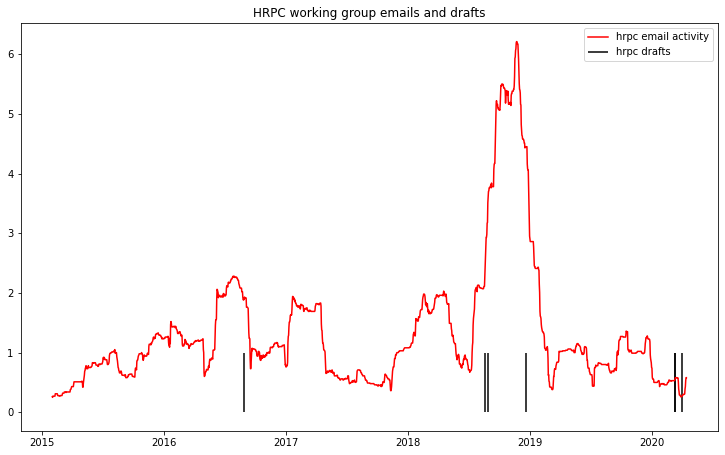

In [9]:
plt.figure(figsize=(12.5, 7.5))

for i, activity in enumerate(activities):

    colors = 'rgbkm'

    ta = activity.sum(1)
    rmta = ta.rolling(window).mean()
    rmtadna = rmta.dropna()
    plt.plot_date(np.array(rmtadna.index),
                  np.array(rmtadna.values),
                  colors[i],
                  label=mailman.get_list_name(urls[i]) + ' email activity',
                  xdate=True)



#plt.plot_date(draft_dates.index, draft_dates.values, label='hrpc drafts')
plt.vlines(draft_dates.index, 0, 1, label='hrpc drafts')

plt.legend()
plt.title("HRPC working group emails and drafts")

plt.savefig("activites-marked.png")
plt.show()